In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [22]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train=(x_train)/255.0
x_test=(x_test)/255.0
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
x_train[0].min(),x_train[0].max()

(0.0, 1.0)

In [4]:
y_train[0]

array([6], dtype=uint8)

In [23]:
class_labels={
    0:'Airplane',
    1:'Automobile',
    2:'Bird',
    3:'Cat',
    4:'Deer',
    5:'Dog',
    6:'Frog',
    7:'Horse',
    8:'Ship',
    9:'Truck'
}

In [24]:
def show_images(images,labels,preds=False):
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        img=images[idx]
        plt.imshow(img)
        if preds:
            plt.title(class_labels[np.argmax(labels[idx])])
        else:
            plt.title(class_labels[labels[idx].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [25]:
from tensorflow.keras.models import Sequential

In [26]:
data_augmentation=Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomTranslation(width_factor=.3,height_factor=.3),
    tf.keras.layers.RandomContrast(.15),
    tf.keras.layers.RandomRotation(.04),
    tf.keras.layers.RandomZoom(.2),
])

In [37]:
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.cache()
train_data=train_data.shuffle(50000)
train_data=train_data.batch(128)
# train_data=train_data.map(lambda x,y:(data_augmentation(x),y))
train_data=train_data.prefetch(64)

test_data=tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_data=test_data.batch(32)
test_data=test_data.prefetch(16)

In [38]:
train_iterator=train_data.as_numpy_iterator()

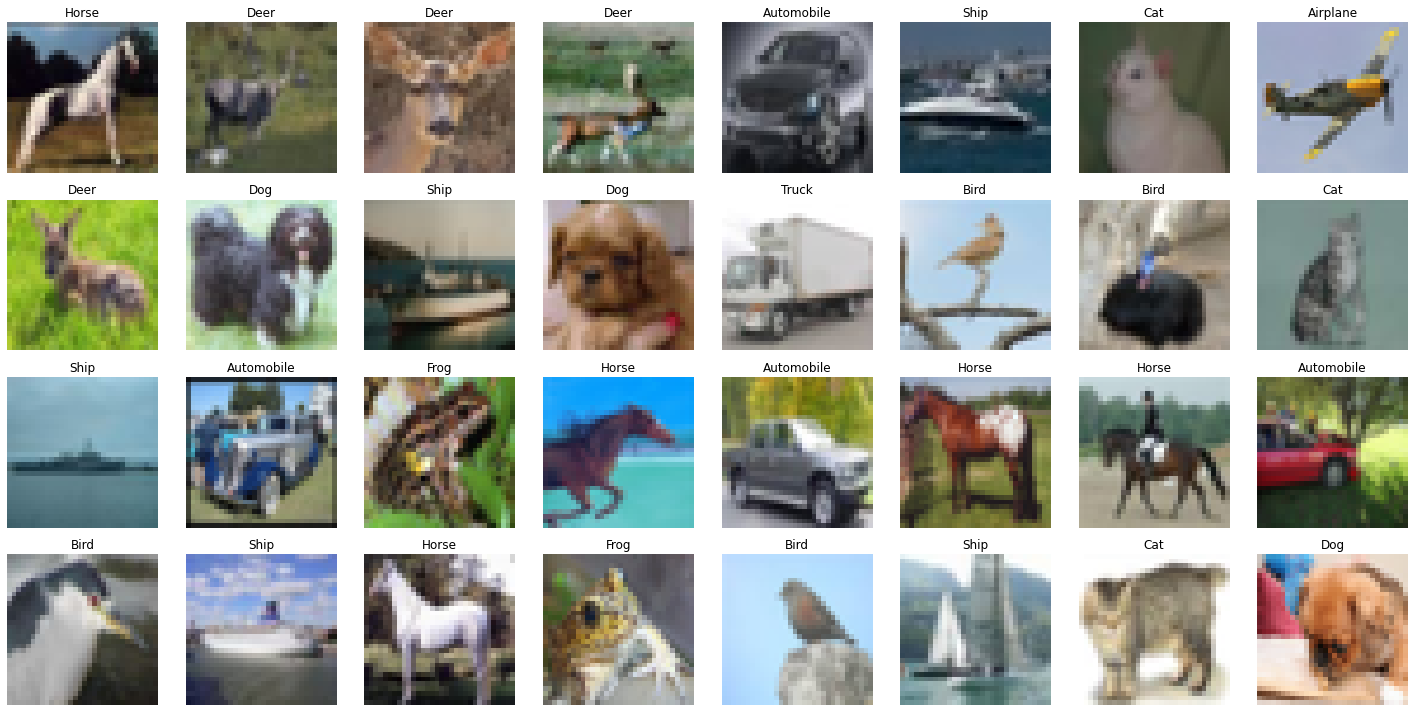

In [29]:
images,labels=train_iterator.next()
show_images(images[:32],labels[:32])

In [32]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,BatchNormalization,MaxPool2D
from tensorflow.keras import Input,Model

In [33]:
def build_model():
    inputs=Input(shape=(32,32,3),name='input_layer')
    x=Conv2D(64,(3,3),1,padding='same',activation='relu')(inputs)
    x=BatchNormalization()(x)
    x=Conv2D(64,(3,3),1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(64,(3,3),1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=MaxPool2D()(x)

    x=Conv2D(128,(3,3),1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(128,(3,3),1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=MaxPool2D()(x)

    x=Flatten()(x)
    x=Dropout(.2)(x)
    x=Dense(256,activation='relu')(x)
    x=BatchNormalization()(x)
    x=Dropout(.2)(x)
    outputs=Dense(10,activation='softmax')(x)

    model=Model(inputs=inputs,outputs=outputs,name='cifar10_model')
    return model

In [34]:
model=build_model()
model.summary()

Model: "cifar10_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)      

In [35]:
model=tf.keras.models.load_model(os.path.join('models','cifar10_model.h5'))

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [24]:
history=model.fit(train_data,epochs=35,validation_data=test_data,callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs')])

Epoch 1/25
391/391 [==============================] - 27s 66ms/step - loss: 1.7952 - accuracy: 0.3647 - val_loss: 2.2367 - val_accuracy: 0.2503
Epoch 2/25
391/391 [==============================] - 27s 69ms/step - loss: 1.4439 - accuracy: 0.4784 - val_loss: 1.3547 - val_accuracy: 0.5253
Epoch 3/25
391/391 [==============================] - 27s 70ms/step - loss: 1.2615 - accuracy: 0.5493 - val_loss: 1.3281 - val_accuracy: 0.5448
Epoch 4/25
391/391 [==============================] - 26s 65ms/step - loss: 1.1357 - accuracy: 0.5968 - val_loss: 1.5136 - val_accuracy: 0.5225
Epoch 5/25
391/391 [==============================] - 26s 67ms/step - loss: 1.0515 - accuracy: 0.6320 - val_loss: 1.2296 - val_accuracy: 0.6039
Epoch 6/25
391/391 [==============================] - 26s 66ms/step - loss: 0.9924 - accuracy: 0.6514 - val_loss: 1.2130 - val_accuracy: 0.6349
Epoch 7/25
391/391 [==============================] - 30s 76ms/step - loss: 0.9396 - accuracy: 0.6713 - val_loss: 0.9276 - val_accuracy:

In [25]:
df=pd.DataFrame(history.history)
df.to_csv('model_loss.csv',index=False)

<Figure size 1440x360 with 0 Axes>

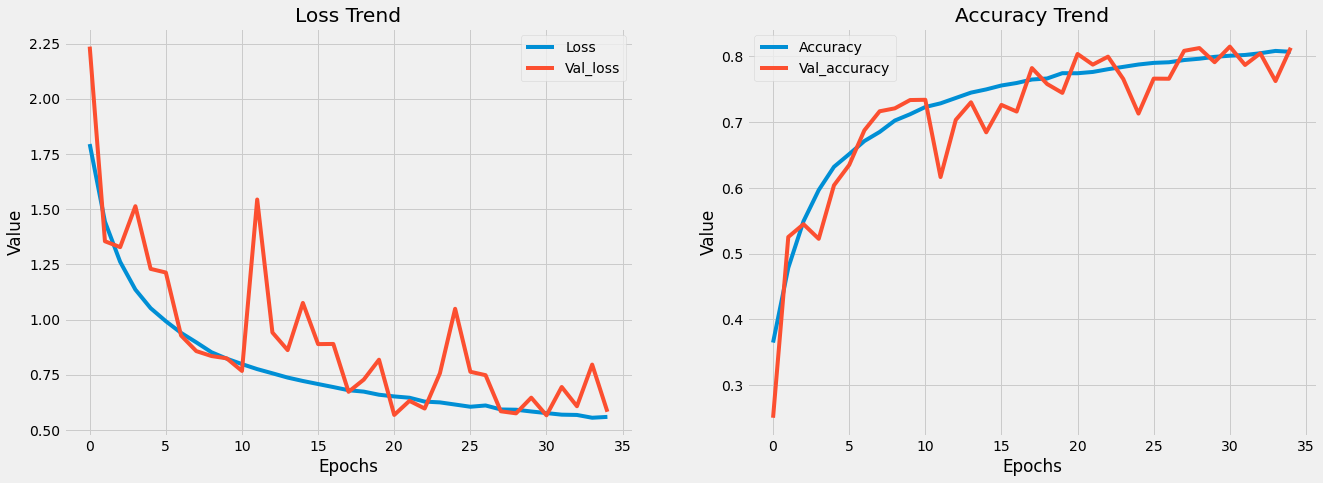

In [36]:
plt.style.use('fivethirtyeight')
df=pd.read_csv('model_loss.csv')
plt.figure(figsize=(20,5))
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,7))
ax1.plot(df['loss'],label='Loss')
ax1.plot(df['val_loss'],label='Val_loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Value')
ax1.set_title('Loss Trend')
ax1.legend()

ax2.plot(df['accuracy'],label='Accuracy')
ax2.plot(df['val_accuracy'],label='Val_accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')
ax2.set_title('Accuracy Trend')
ax2.legend()

plt.show()

In [30]:
# tf.keras.models.save_model(model,os.path.join('models','cifar10_model.h5'))
# model.save('./metadata/')

INFO:tensorflow:Assets written to: ./metadata/assets


INFO:tensorflow:Assets written to: ./metadata/assets


## Predictions on training dataset

4/4 [==============================] - 2s 132ms/step


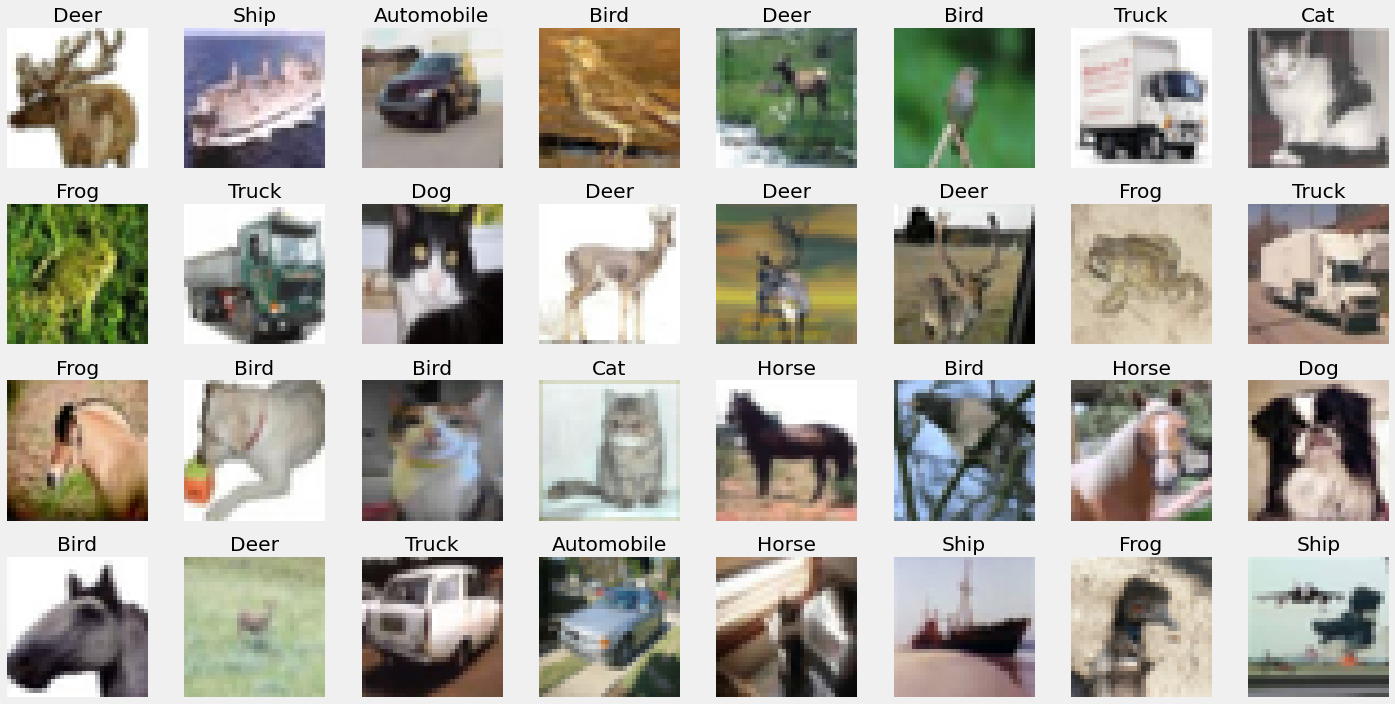

In [39]:
images,labels=train_iterator.next()
pred=model.predict(images)
show_images(images[:32],pred[:32],True)

## Predictions on testing dataset

In [42]:
loss,acc=model.evaluate(x_test,y_test,verbose=0)
print(f'Model Loss: {loss:.4f}')
print(f'Model Accuracy: {acc*100:.3f} %')

Model Loss: 0.5822
Model Accuracy: 81.330 %


In [43]:
preds=model.predict(x_test,verbose=0)

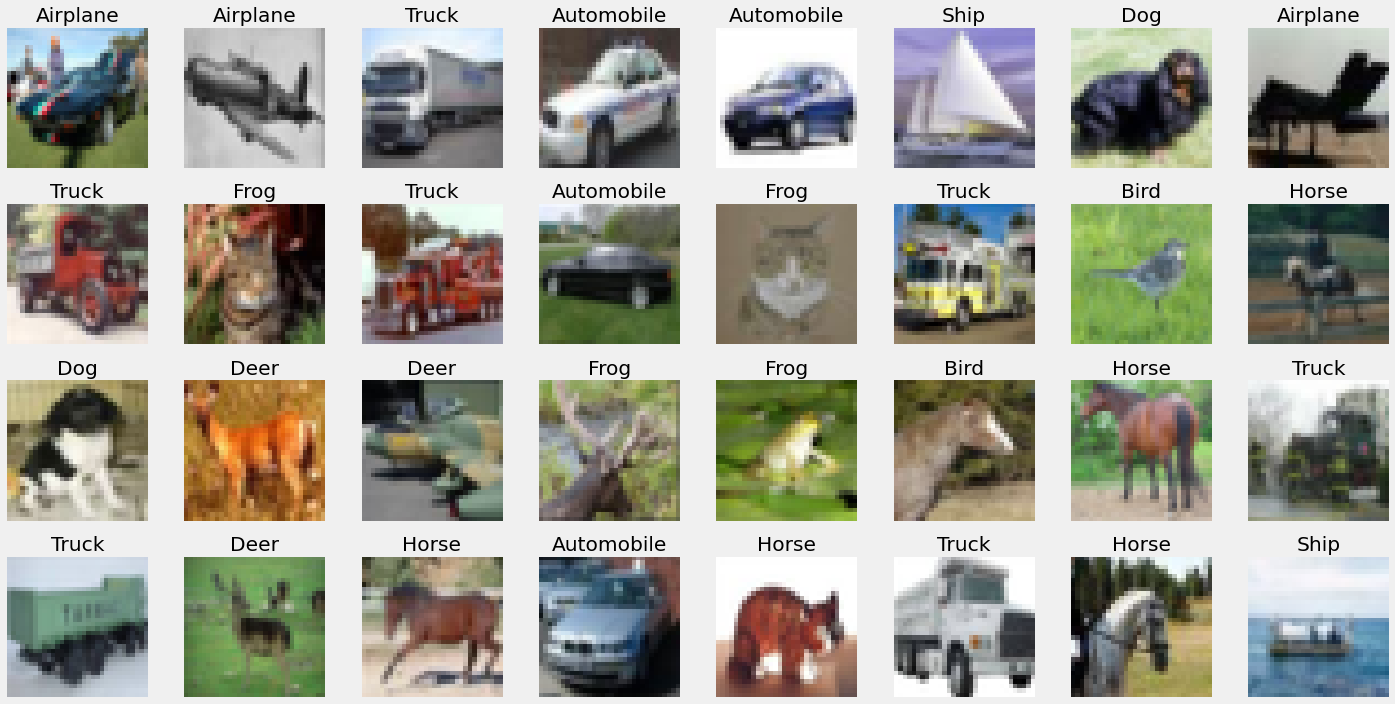

In [44]:
indexes=np.random.randint(0,9999,size=(32,))
images=np.expand_dims(x_test[indexes[0]],axis=0)
pred=np.expand_dims(preds[indexes[0]],axis=0)
for i in range(1,len(indexes)):
    images=np.concatenate([images,np.expand_dims(x_test[indexes[i]],axis=0)],axis=0)
    pred=np.concatenate([pred,np.expand_dims(preds[indexes[i]],axis=0)],axis=0)
show_images(images,pred,True)